You can **use only these** 3rd party **packages:** `cv2, pandas, keras, matplotlib, numpy, sklearn, skimage, tensorflow`.

### Description
In this assignment you have to build a model for super-resolution using tf.keras. You have to train a CNN to upscale small image patches, then use the trained model to upscale full images. To implement such kind of model, you should take a look at the following classes and methods: `Sequential model, Functional API, Conv2D, cv2.cvtColor (BGR2YCrCb, YCrCb2RGB, YCrCb2BGR)`.


## Prepare dataset

### BSDS300
* LR: Low resolution, HR: high resolution, SR: super resolution
* Download the BSDS300 dataset. Here you can find more information about the dataset: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/
* After extracting it, convert them to YCrCb color space. We will use the luminance information (0th channel) only as the input of the CNN.
* Create 32x32 image patches with a sliding window (16 step size).
* Use 0.15 part of the train set as the validation set.
* The Y (0th) channel of the original images will be the ground truth. Create the LR images by resizing them half of the original size, then resize it back to the original size using cubic interpolation.
* Print the size of each set and plot 5 LR training images and their corresponding HR images. *Note: Don't forget to convert the color space from YCrCb back to RGB before plotting.*
* Normalize the datasets. All value should be between 0.0 and 1.0. *Note: you don't have to use standardization, you can just divide them by 255.*

In [ ]:
# BSDS300 dataset
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-images.tgz
!tar -xvzf BSDS300-images.tgz

--2020-10-21 11:23:26--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-images.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.189.73
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22211847 (21M) [application/x-tar]
Saving to: ‘BSDS300-images.tgz’

BSDS300-images.tgz  100%[===================>]  21.18M  11.1MB/s    in 1.9s    

2020-10-21 11:23:29 (11.1 MB/s) - ‘BSDS300-images.tgz’ saved [22211847/22211847]

BSDS300/images/
BSDS300/images/train/
BSDS300/images/train/159029.jpg
BSDS300/images/train/20008.jpg
BSDS300/images/train/155060.jpg
BSDS300/images/train/286092.jpg
BSDS300/images/train/100075.jpg
BSDS300/images/train/61060.jpg
BSDS300/images/train/46076.jpg
BSDS300/images/train/301007.jpg
BSDS300/images/train/26031.jpg
BSDS300/images/train/232038.jpg
BSDS300/images/train/45077.jpg
BSDS300/images/train/365025.jpg
BSDS30

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas
import skimage
import sklearn
from typing import List, Tuple

In [ ]:
#321 481
#481 321

def create_perfect_size(image: np.ndarray) -> np.ndarray:
  return image[:-1,:-1,0]

def create_image_patches(image: np.ndarray) -> List[np.ndarray]:
  stride: int = 16
  patch_size: int = 32
  height, width = image.shape
  patches: List[np.ndarray] = []
  for i in range(0,height - stride,stride):
    for j in range(0,width - stride,stride):
      patch = image[i:i+patch_size,j:j+patch_size]
      patches.append(patch)
  return patches

def create_low_res_image(image: np.ndarray) -> np.ndarray:

  def create_dimension(image: np.ndarray, percentage: int) -> Tuple[int,int]:
    width = int(image.shape[1] * percentage / 100)
    height = int(image.shape[0] * percentage / 100)
    return (width, height)
  
  small_image = cv2.resize(image, create_dimension(image, 50), interpolation = cv2.INTER_CUBIC)
  resized_back_image = cv2.resize(small_image, create_dimension(small_image, 200), interpolation = cv2.INTER_CUBIC)
  return resized_back_image

def read_image_files_in_yCbCr(folder: str, filename: str) -> List[np.ndarray]:
  path = '/content/BSDS300'
  images_yCbCr = []
  with open(path + '/' + filename,'r') as file:
    for line in file:
      filename = line.rstrip()
      if filename != '':
        image_path = path + '/images/' + folder + '/' + filename + '.jpg'
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        images_yCbCr.append(img)
  print(len(images_yCbCr))
  return images_yCbCr

def generate_LR_HR_sets(input_set: List[np.ndarray]) -> Tuple[List[np.ndarray],List[np.ndarray]]:
  HR_set = []
  LR_set = []
  for image in input_set:
    high_res_patches = create_image_patches(image)
    low_res_image = create_low_res_image(image)
    low_res_patches = create_image_patches(low_res_image)
    HR_set.extend(high_res_patches)
    LR_set.extend(low_res_patches)
  return (HR_set,LR_set)


In [ ]:
#Reading and preprocessing data
train_input_raw = read_image_files_in_yCbCr('train','iids_train.txt')
test_input_raw = read_image_files_in_yCbCr('test','iids_test.txt')

train_input = [create_perfect_size(raw_image) for raw_image in train_input_raw]
test_input = [create_perfect_size(raw_image) for raw_image in test_input_raw]

train_HR, train_LR = generate_LR_HR_sets(train_input)
test_HR, test_LR = generate_LR_HR_sets(test_input)

200
100


In [ ]:
#split dataset
from sklearn.model_selection import train_test_split

x_train_high_res, x_valid_high_res, = train_test_split(train_HR, test_size=0.15, random_state=42)
x_train_low_res, x_valid_low_res = train_test_split(train_LR, test_size=0.15, random_state=42)
print("Training HR: " + str(len(x_train_high_res)),"Validation HR: " + str(len(x_valid_high_res)))
print("Training LR: " + str(len(x_train_low_res)),"Validation LR: " + str(len(x_valid_low_res)))
print("Test HR: " + str(len(test_HR)),"Test LR: " + str(len(test_LR)))

Training HR: 93670 Validation HR: 16530
Training LR: 93670 Validation LR: 16530
Test HR: 55100 Test LR: 55100


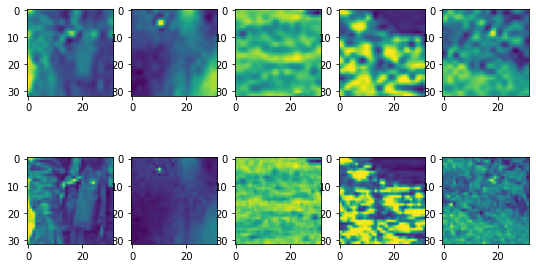

In [ ]:
#Displaying 5 LR and HR training images

random_indexes = [321,7384,43232,57834,87632]
plt.figure(figsize=(9,5))

for i in range(10):
    plt.subplot(2,5,i+1)
    if i >= 5:
      plt.imshow(x_train_high_res[random_indexes[i%5]])
    else:
      plt.imshow(x_train_low_res[random_indexes[i%5]])
plt.show()

In [ ]:
#Normalizing datasets
x_train_high_res_normalized = [image / 255.0 for image in x_train_high_res]
x_valid_high_res_normalized = [image / 255.0 for image in x_valid_high_res]
x_train_low_res_normalized = [image / 255.0 for image in x_train_low_res]
x_valid_low_res_normalized = [image / 255.0 for image in x_valid_low_res]

test_high_res_normalized = [image / 255.0 for image in test_HR]
test_low_res_normalized = [image / 255.0 for image in test_LR]

## Define the model
Define the following architecture in tf.keras:
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 32, 32, 128)       10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 1)         1601      
=================================================================
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________
```
* Use 9x9, 3x3 and 5x5 kernels with `relu`, `relu` and `linear` activations in `conv2d`, `conv2d_1` and `conv2d_2`, respectively.
* For optimizer use Adam, and MSE as loss function.


In [ ]:
%tensorflow_version 2.x
from tensorflow.keras import layers, models

def create_CNN(input_shape: Tuple[int,int,int] = (None,None,1)) -> models.Sequential:
  model = models.Sequential()
  model.add(layers.Conv2D(128, (9, 9), padding= 'same' ,activation='relu', input_shape=input_shape))
  model.add(layers.Conv2D(64, (3, 3), padding= 'same', activation='relu'))
  model.add(layers.Conv2D(1, (5, 5), padding= 'same', activation='linear'))
  model.compile(optimizer = 'adam',loss = 'mean_squared_error',metrics=['mse', 'mae'])
  return model

model = create_CNN(input_shape=(32,32,1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 128)       10496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 1)         1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def reshape_sets(input_set: List[np.ndarray]) -> np.ndarray:
  reshaped = np.stack(input_set)
  size = reshaped.shape[0]
  reshaped = reshaped.reshape([size,32,32,1])
  return reshaped

X_TRAIN_HR_N = reshape_sets(x_train_high_res_normalized)
X_VALID_HR_N = reshape_sets(x_valid_high_res_normalized)
X_TRAIN_LR_N = reshape_sets(x_train_low_res_normalized)
X_VALID_LR_N = reshape_sets(x_valid_low_res_normalized)

Y_TEST_HR_N = reshape_sets(test_high_res_normalized)
Y_TEST_LR_N = reshape_sets(test_low_res_normalized)

## Training and evaluation 
  * Create separate model definitions: one for training small image patches and the other is for predicting on full images.
  * Train the model on the LR image patches for 10 epochs without early stopping.
  * Plot the training curve (train/validation loss and mse).
  * Evaluate the trained model on the test set.
  * Create a prediction model, load the pretrained weights.
  * Plot some (5) examples. (HR, LR [cubic], SR  [prediction] triplets.) 
  * Calculate commonly used super-resolution metrics between HR/LR and HR/SR images. The metrics are: Peak Signal-to-Noise Ratio (PSNR) [20*log10(255/rmse)], Structural Similarity (SSIM) [skimage.measure package, compare_ssim function] and the MSE as well.

*Note: Don't forget to convert the color space from YCrCb back to RGB before plotting and metric calculation.*

In [ ]:
#Training the model
epochs = 10
batch_size = 32
print(X_TRAIN_HR_N.shape)
history = model.fit(x = X_TRAIN_LR_N,
                    y = X_TRAIN_HR_N,
                    epochs = epochs,
                    #steps_per_epoch = X_TRAIN_HR_N.shape[0] // batch_size,
                    validation_data= (X_VALID_LR_N, X_VALID_HR_N),
                    verbose=1)

(93670, 32, 32, 1)
Epoch 1/10
2928/2928 [==============================] - 43s 15ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0258 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0233
Epoch 2/10
2928/2928 [==============================] - 42s 14ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0235 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0227
Epoch 3/10
2928/2928 [==============================] - 43s 15ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0229 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0225
Epoch 4/10
2928/2928 [==============================] - 43s 15ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0226 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0221
Epoch 5/10
2928/2928 [==============================] - 42s 14ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0225 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0226
Epoch 6/10
2928/2928 [==============================] - 42s 14ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0223 - val_loss: 0.0016 - val_mse

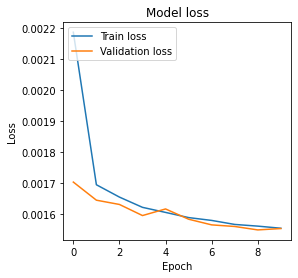

In [ ]:
#Plotting results
plt.figure(figsize=(9,4))

# Plot training & validation loss values
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')

# Plot history: MSE
#plt.subplot(1,2,2)
#plt.plot(history.history['mse'])
#plt.plot(history.history['val_mse'])
#plt.title('MSE')
#plt.ylabel('MSE value')
#plt.xlabel('Epoch')
#plt.legend(['MSE (training data)','MSE (validation data)'], loc="upper left")

#This time MSE is the loss function
plt.show()

In [ ]:
#Evaluate trained model on test set
loss, mse, mae = model.evaluate(Y_TEST_LR_N, Y_TEST_HR_N, verbose=0)

print('Test loss: {}'.format(loss))

Test loss: 0.0017623837338760495


In [ ]:
filepath = '/content/weights/trained_weights.tf' 
model.save_weights(filepath= filepath)
#Prediction model, loading pretrained weights
prediction_model = create_CNN()
prediction_model.load_weights(filepath= filepath)

In [ ]:
def generate_SR_patch_from_HR(hr_patch: np.ndarray) -> np.ndarray:
  reshaped = hr_patch.reshape([1,32,32,1])
  prediction = (prediction_model.predict(reshaped) * 255).astype(np.int)
  return prediction.reshape(32,32)

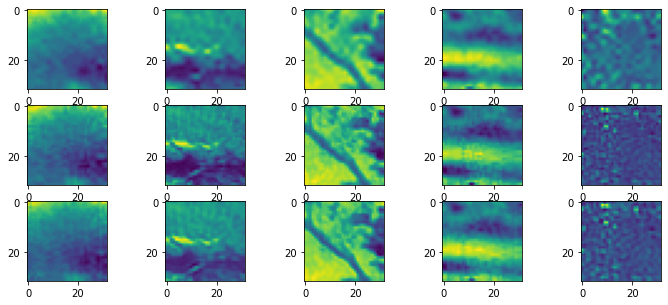

In [ ]:
#Displaying 5 LR HR SR patches
some_LR_HR_SR_patches = [x_train_low_res[:5],x_train_high_res[:5],[generate_SR_patch_from_HR(image) for image in x_train_high_res_normalized[:5]]]
some_LR_HR_SR_patches = [item for innerlist in some_LR_HR_SR_patches for item in innerlist]

plt.figure(figsize=(12,5))

for i in range(len(some_LR_HR_SR_patches)):
    plt.subplot(3,5,i+1)
    plt.imshow(some_LR_HR_SR_patches[i])
plt.show()

In [ ]:
#def generate_final_LR_HR_SR_images(image_input: np.ndarray) -> List[np.ndarray]:
#  original_image = image_input[:-1,:-1,:]
#
#  #LR image
#  image_for_test_LR = np.copy(original_image)
#  tmp_y_channel = image_for_test_LR[:,:,0]
#  tmp_y_channel_lr = create_low_res_image(tmp_y_channel)
#  image_for_test_LR[:,:,0] = tmp_y_channel_lr
#
#  #HR image
#  image_for_test_HR = np.copy(original_image)
#
#  #SR image
#  image_for_test_SR = np.copy(original_image)
#  sr_y_channel = image_for_test_SR[:,:,0]
#  patches_for_sampling = create_image_patches(sr_y_channel)
#  normalized_patches = [patch / 255.0 for patch in patches_for_sampling]
#  predicted_patches = [generate_SR_patch_from_HR(sample) for sample in normalized_patches]
#  height, width = sr_y_channel.shape
#  stride: int = 16
#  patch_size: int = 32
#  current_patch_index = 0
#  result = np.zeros(shape=(height,width))
#  for i in range(0,height - stride,stride):
#      for j in range(0,width - stride,stride):
#        #sr_y_channel[i:i+patch_size,j:j+patch_size] = predicted_patches[current_patch_index]
#        result[i:i+patch_size,j:j+patch_size] = predicted_patches[current_patch_index]
#        current_patch_index += 1
#  image_for_test_SR[:,:,0] = result
#
#  image_for_test_LR = cv2.cvtColor(image_for_test_LR, cv2.COLOR_YCrCb2RGB)
#  image_for_test_HR = cv2.cvtColor(image_for_test_HR, cv2.COLOR_YCrCb2RGB)
#  image_for_test_SR = cv2.cvtColor(image_for_test_SR, cv2.COLOR_YCrCb2RGB)
#  return [image_for_test_LR,image_for_test_HR,image_for_test_SR]


#UPDATE: this is the correct solution
def predict_test_image(image_input: np.ndarray) -> List[np.ndarray]:
  original_image = image_input[:-1,:-1,:]

  #LR image
  image_for_test_LR = np.copy(original_image)
  tmp_y_channel = image_for_test_LR[:,:,0]
  tmp_y_channel_lr = create_low_res_image(tmp_y_channel)
  image_for_test_LR[:,:,0] = tmp_y_channel_lr

  #HR image
  image_for_test_HR = np.copy(original_image)

  #SR image
  image_for_test_SR = np.copy(original_image)
  sr_y_channel = image_for_test_SR[:,:,0]
  height, width = sr_y_channel.shape
  reshaped = sr_y_channel.reshape([1,height,width,1]) / 255.0
  pred = (prediction_model.predict(reshaped) * 255).astype(np.int)
  image_for_test_SR[:,:,0] = pred.reshape([height, width])

  image_for_test_LR = cv2.cvtColor(image_for_test_LR, cv2.COLOR_YCrCb2RGB)
  image_for_test_HR = cv2.cvtColor(image_for_test_HR, cv2.COLOR_YCrCb2RGB)
  image_for_test_SR = cv2.cvtColor(image_for_test_SR, cv2.COLOR_YCrCb2RGB)
  return [image_for_test_LR,image_for_test_HR,image_for_test_SR]

In [ ]:
#Getting final images
indexes = [23,36,44,69,78]
images_final = [predict_test_image(test_input_raw[index]) for index in indexes]

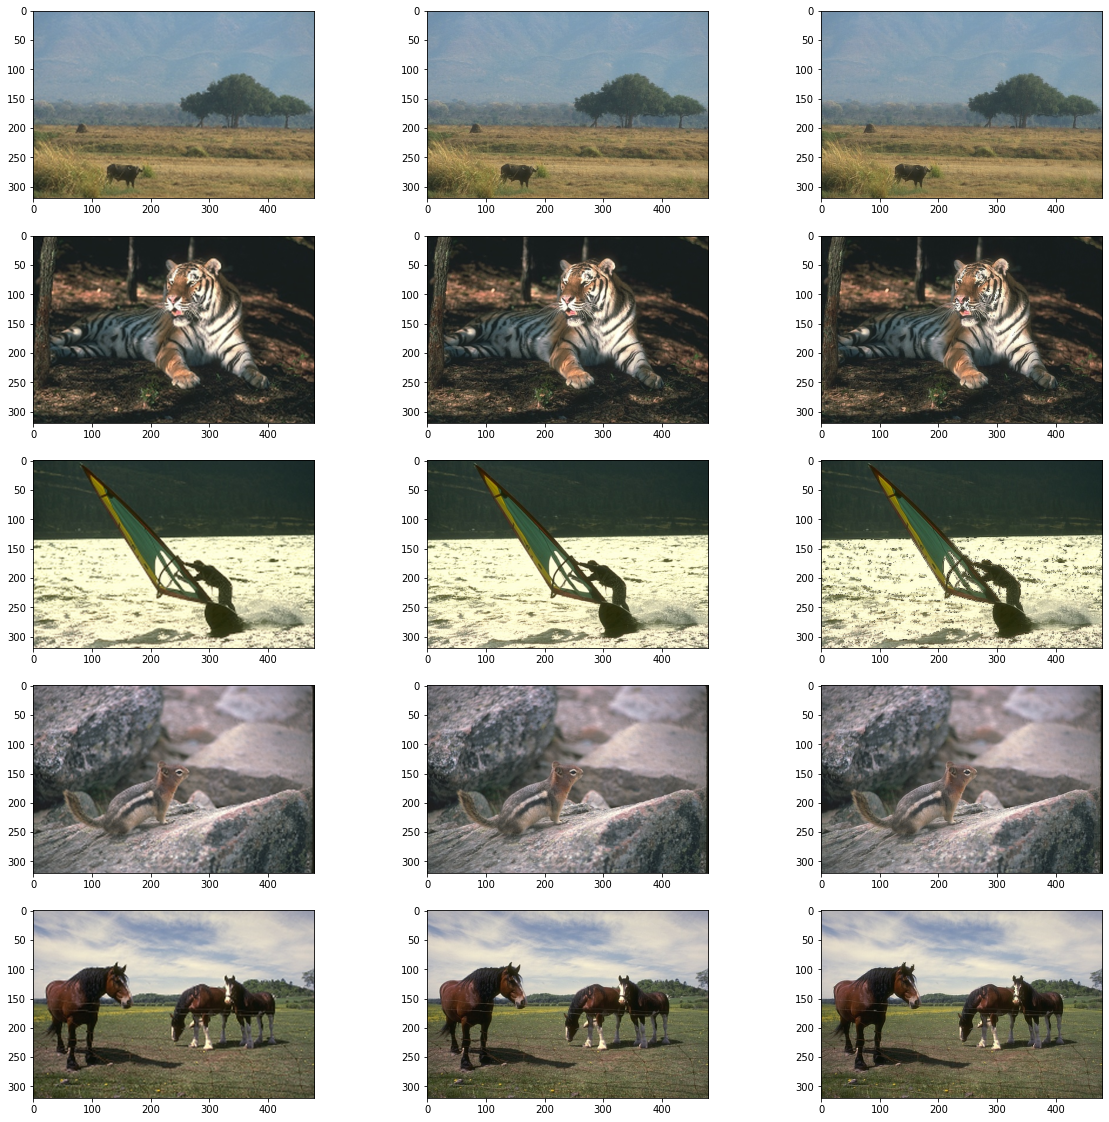

In [ ]:
img_store = [item for innerlist in images_final for item in innerlist]
plt.figure(figsize=(20,20))

for i in range(len(img_store)):
    plt.subplot(5,3,i+1)
    plt.imshow(img_store[i])
plt.show()

In [ ]:
#Measures
def calculate_PSNR(image1: np.ndarray, image2: np.ndarray) -> float:
  height, width, dim = image1.shape
  result = 0.0
  for i in range(dim):
    for j in range(height):
      for k in range(width):
        tmp = image1[j,k,i] - image2[j,k,i].astype(float)
        result += np.square(tmp)
  rmse = np.sqrt(result)
  return 20*np.log10(255/rmse)

In [ ]:
#PSNR
for i in range(5):
  print(i+1,'.PSNR: LR-HR',calculate_PSNR(images_final[i][0],images_final[i][1]),'PSNR: HR-SR',calculate_PSNR(images_final[i][1],images_final[i][2]))

1 .PSNR: LR-HR -23.847994409224963 PSNR: HR-SR -16.877664972256884
2 .PSNR: LR-HR -27.32141694839168 PSNR: HR-SR -29.329937742463663
3 .PSNR: LR-HR -30.837656617637805 PSNR: HR-SR -38.67598270090811
4 .PSNR: LR-HR -23.80829266490747 PSNR: HR-SR -18.13214110551733
5 .PSNR: LR-HR -28.145501605697522 PSNR: HR-SR -24.853825482524332


In [ ]:
#SSIM
from skimage.metrics import structural_similarity as ssim
for i in range(5):
  print(i+1,'.SSIM: LR-HR',ssim(im1 = images_final[i][0], im2 = images_final[i][1], multichannel= True, dynamic_range=255),'SSIM: HR-SR',ssim(im1 = images_final[i][1], im2 = images_final[i][2], multichannel= True,dynamic_range=255))

1 .SSIM: LR-HR 0.8828081849401608 SSIM: HR-SR 0.9768660775440909
2 .SSIM: LR-HR 0.9082896596811817 SSIM: HR-SR 0.9689434305342824
3 .SSIM: LR-HR 0.8731436764264707 SSIM: HR-SR 0.7922626247757499
4 .SSIM: LR-HR 0.9432736060079906 SSIM: HR-SR 0.9880031842915944
5 .SSIM: LR-HR 0.8318321197521378 SSIM: HR-SR 0.9604388635049702


In [ ]:
#MSE
from skimage.metrics import mean_squared_error
for i in range(5):
  print(i+1,'.MSE: LR-HR',mean_squared_error(images_final[i][0],images_final[i][1]),'MSE: HR-SR',mean_squared_error(images_final[i][1],images_final[i][2]))

1 .MSE: LR-HR 34.22688151041667 MSE: HR-SR 6.8759765625
2 .MSE: LR-HR 76.15695746527778 MSE: HR-SR 120.93768880208333
3 .MSE: LR-HR 171.13291666666666 MSE: HR-SR 1040.3181141493055
4 .MSE: LR-HR 33.915416666666665 MSE: HR-SR 9.178717447916666
5 .MSE: LR-HR 92.06998046875 MSE: HR-SR 43.146983506944444
